In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)

#from dis2p.dis2pvi import Dis2pVI
# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Global seed set to 0
Global seed set to 0


# prepare data: Heart Atlas

Define function to convert covariate names to numerical values

In [2]:
def create_cats_idx(adata, cats):
    # create numerical index for each attr in cats

    for i in range(len(cats)):
        values = list(set(adata.obs[cats[i]]))

        val_to_idx = {v: values.index(v) for v in values}

        idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]

        adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

    return adata

Load and subsample the heart atlas dataset from Litvinukova et al. Nature 2020

In [3]:
#adata = scvi.data.heart_cell_atlas_subsampled()
adata = sc.read("data/hca_subsampled_20k.h5ad")

# preprocess dataset
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

# specify name of dataset 
data_name = 'HeartAtlas'

# specify attributes
cats = ['cell_type', 'cell_source', 'gender', 'region']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

# save adata
# adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

# train model: dis2p(n_cf=1)

In [4]:
from dis2p.dis2pvi import Dis2pVI

In [ ]:
# train params
epochs = 100
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'n_cf': n_cf}

module_name = 'dis2p'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
try:
    model = Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# trains the model (if not trained before) and save it into: pre_path + model_name
except:

    Dis2pVI.setup_anndata(
        adata,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    model = Dis2pVI(adata, n_layers=n_layers)
    model.train(**train_dict)
    model.save(f"{pre_path}/{model_name}")

INFO     No backup URL provided for missing file                                                                   
         models/dis2p/2024-03-16,dis2p,HeartAtlas,n_layers=1,max_epochs=100,batch_size=128,cf_weight=1,beta=1,clf_w
         eight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt                                                   


CUDA backend failed to initialize: Found CUDA version 11070, but JAX was built against version 11080, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/pytorch_lightning/core/optimizer.py:331: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 24/100:  23%|▏| 23/100 [09:05<30:40, 23.90s/it, v_num=1, loss_validation=2.16e+3, x_0_validation=291, x_1_validation=299, x_2_validation=299, x_3_validation=297

# get latent space

In [6]:
# load model
pre_path = f'models/dis2p'
model_name = f'{today},dis2p,HeartAtlas,n_layers=1,max_epochs=400,batch_size=128,cf_weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1'
#model = Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# Z_0
adata.obsm[f'dis2p_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

# plot UMAP latent

In [9]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)

---UMAP for dis2p_Z_0---


/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:12

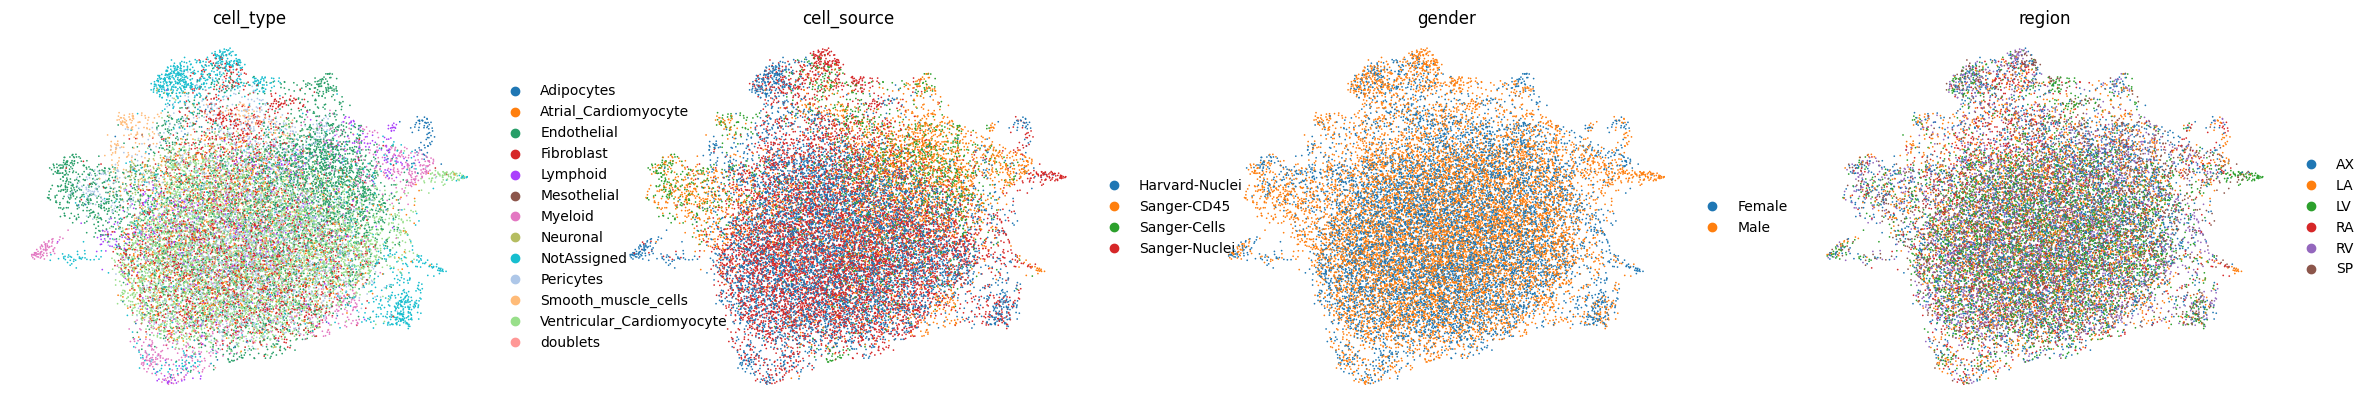

---UMAP for dis2p_Z_1---


/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:12

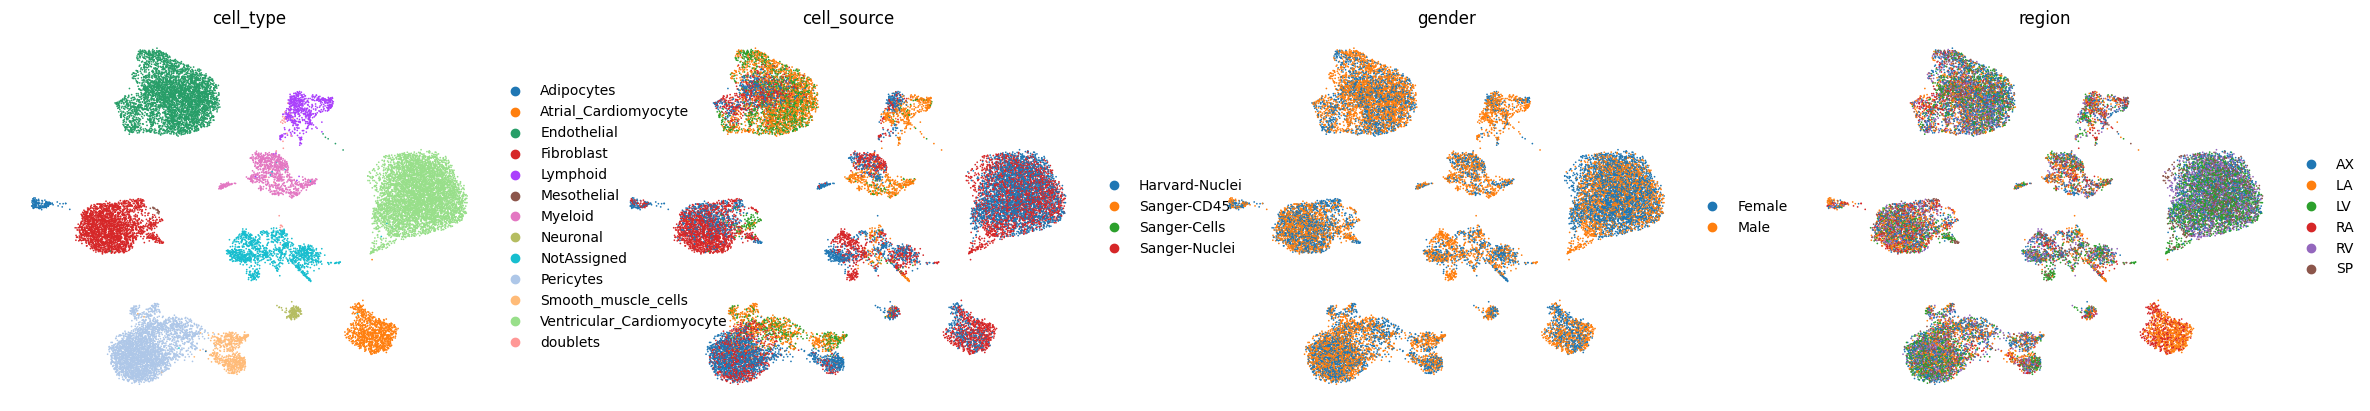

---UMAP for dis2p_Z_2---


/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:12

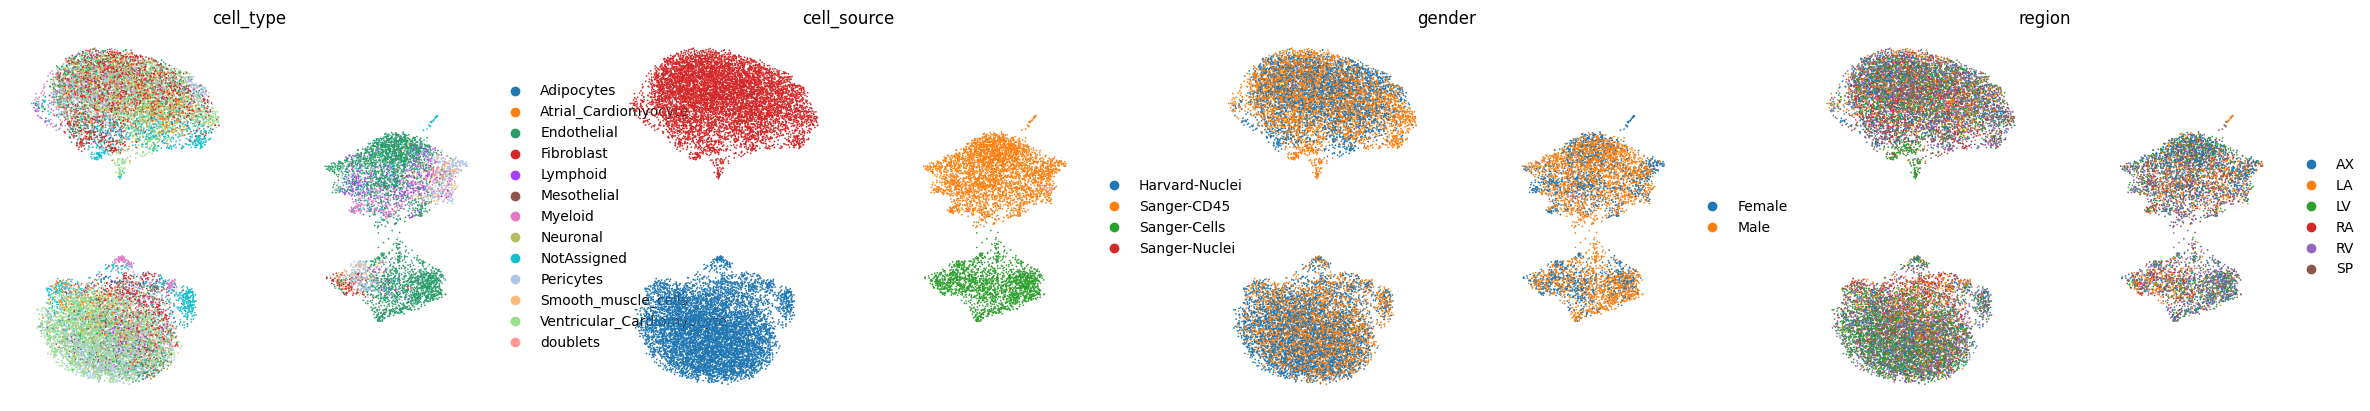

---UMAP for dis2p_Z_3---


/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:12

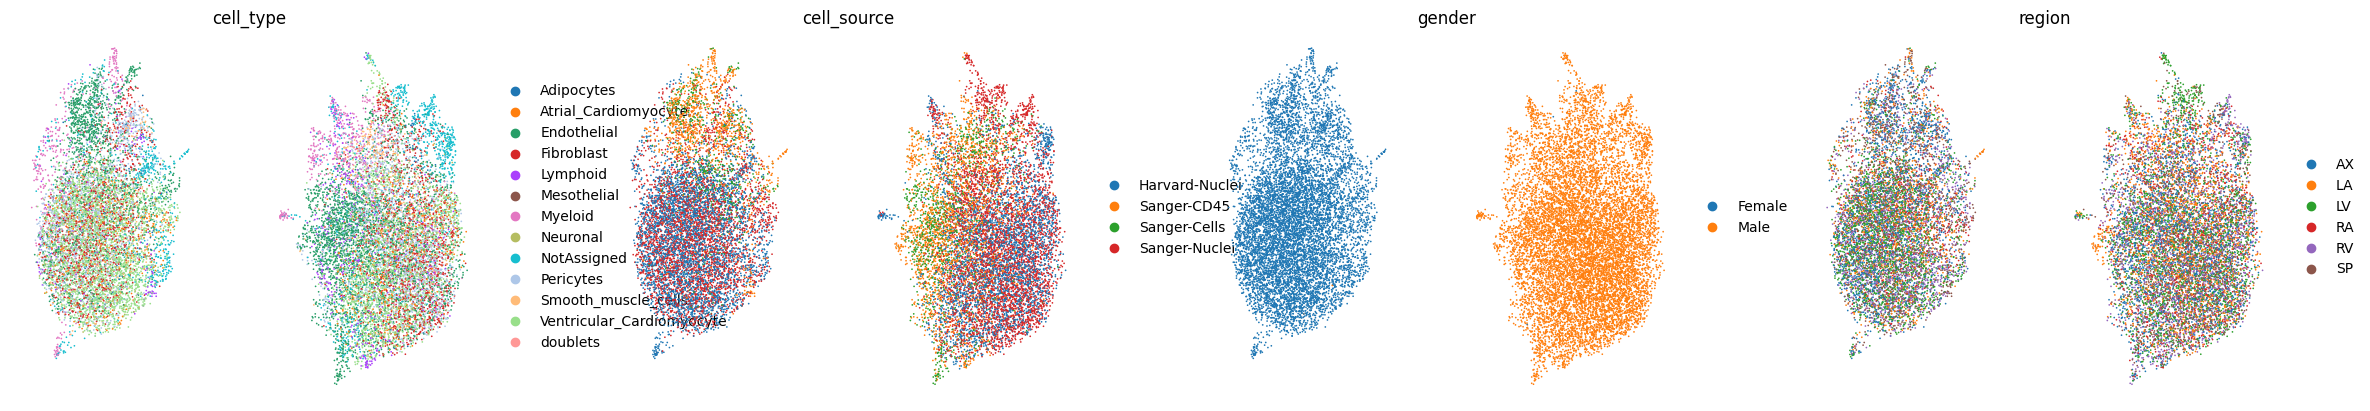

---UMAP for dis2p_Z_4---


/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:12

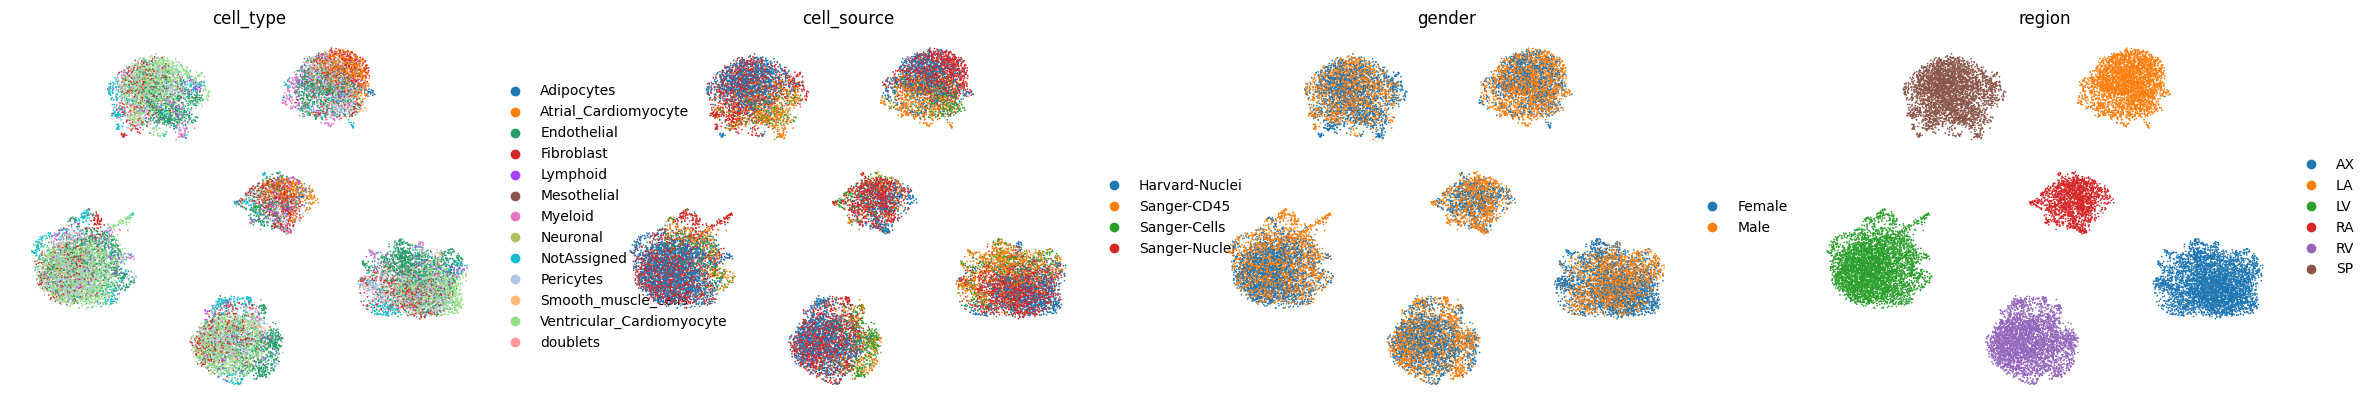

In [10]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )

# Perform MIG benchmarking

In [12]:
from metrics.benchmark_VAE.vi import VI
from metrics.metrics import *

# import from scib_metrics
from metrics.scib_metrics_dev.src.scib_metrics.benchmark import Benchmarker


In [13]:
MI, MI_not_max, MI_not, MI_dif_max, MI_dif, maxMIG, concatMIG = Mixed_KSG_MI_metrics(adata, cats, module_name)

# DP, EO
create_cats_idx(adata, ['NRP'])
y_name = 'NRP_idx'
acc, DP_diff, EO_diff = fair_clf_metrics(adata, cats, y_name, module_name)

# classifier Si
acc, acc_not_concat, acc_not_max, acc_gap_concat, acc_gap_max = clf_S_Z_metrics(adata, cats, module_name)


# convert results to dataframes
df_MI = pd.DataFrame(
      [MI, MI_not_max, MI_not, MI_dif_max, MI_dif]
)

df_fairness = pd.DataFrame(
      [acc, DP_diff, EO_diff]
)

df_acc = pd.DataFrame(
      [acc, acc_not_concat, acc_not_max, acc_gap_concat, acc_gap_max]
)

# create output folder and save csv
metrics_dir = f'metrics/{module_name}/'
os.makedirs(metrics_dir, exist_ok=True)  
df_acc.to_csv(metrics_dir+model_name+',acc.csv')
df_fairness.to_csv(metrics_dir+model_name+',fair.csv') 
df_MI.to_csv(metrics_dir+model_name+',MI.csv')


Method: dis2p
Mixed_KSG Mutual Information metrics
MI(Z_1 ; S_1) = 1.8997,  MI((Z - Z_1) ; S_1) = 0.7986, max MI((Z_j!=1) ; S_1) = 0.9674
MI(Z_2 ; S_2) = 1.2357,  MI((Z - Z_2) ; S_2) = 0.2525, max MI((Z_j!=2) ; S_2) = 0.5530
MI(Z_3 ; S_3) = 0.6708,  MI((Z - Z_3) ; S_3) = 0.1253, max MI((Z_j!=3) ; S_3) = 0.1562


KeyboardInterrupt: 

In [ ]:
adata.obs.head()